In [1]:
import pyLDAvis.gensim
#from pipeline import TopicModeller
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
from gensim import corpora
#pyLDAvis.enable_notebook()
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel, LdaMulticore
#import tm_functions
import matplotlib.pyplot as plt
%matplotlib inline

import re
import tm_functions

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/midzay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
from nltk.corpus import stopwords

In [4]:
stop_words = stopwords.words('russian')
STOPLIST = set(stop_words)
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","«","»"]

In [5]:
with open('../../../../nlp/preprocessing/stopwords.txt') as sw:
    text =sw.read().splitlines()
for t in text:
    STOPLIST.add(t)
STOPLIST.add('—')

In [6]:
PATH ='/home/midzay/Mlerning/DATASET/proj_news_viz/small/lemma/'
file='economic.csv.bz2'

In [7]:
data = pd.read_csv(PATH + file , encoding='utf-8')
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,Получение финансовой помощи от МВФ станет для ...,Экономика,получение финансовый помощь мвф россия затрудн...
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...","На своем пятничном заседании Госдума, несмотря...",Экономика,пятничный заседание госдума несмотря возражени...
2,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/imf/,NaN,Мир,Мишель Камдессю уходит в отставку?,Мишель Камдессю может покинуть пост директора-...,Экономика,мишель камдесся покинуть пост директор-распоря...
3,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/tumen/,NaN,Экономика,Прибыль Тюменнефтегаза возросла в 10 раз,"Нераспределенная прибыль ОАО ""Тюменнефтегаз"", ...",Экономика,нераспределенный прибыль оао тюменнефтегаз доч...
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/volkswagen/,NaN,Экономика,"Volkswagen выкупает остатки акций ""Шкоды""",Германский автопромышленный концерн Volkswagen...,Экономика,германский автопромышленный концерн volkswagen...


In [8]:
def pre_proc(text):
    tokens = [tok for tok in text.split() if tok not in STOPLIST]
    return tokens
    

In [9]:
data['new_text']=data.text_lema.apply(pre_proc)

In [10]:
data.head()

,1914-lenta/,url,edition,topics,title,text,topic,text_lema,new_text
0,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/imf/,NaN,Россия,МВФ требует от Центробанка закрыть зарубежные ...,Получение финансовой помощи от МВФ станет для ...,Экономика,получение финансовый помощь мвф россия затрудн...,"[получение, финансовый, помощь, мвф, россия, з..."
1,1999-10-01 12:00:00,https://lenta.ru/news/1999/10/01/nds/,NaN,Россия,"Госдума изменила ставки НДС, несмотря на возра...","На своем пятничном заседании Госдума, несмотря...",Экономика,пятничный заседание госдума несмотря возражени...,"[пятничный, заседание, госдума, несмотря, возр..."
2,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/imf/,NaN,Мир,Мишель Камдессю уходит в отставку?,Мишель Камдессю может покинуть пост директора-...,Экономика,мишель камдесся покинуть пост директор-распоря...,"[мишель, камдесся, покинуть, пост, директор-ра..."
3,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/tumen/,NaN,Экономика,Прибыль Тюменнефтегаза возросла в 10 раз,"Нераспределенная прибыль ОАО ""Тюменнефтегаз"", ...",Экономика,нераспределенный прибыль оао тюменнефтегаз доч...,"[нераспределенный, прибыль, оао, тюменнефтегаз..."
4,1999-10-04 12:00:00,https://lenta.ru/news/1999/10/04/volkswagen/,NaN,Экономика,"Volkswagen выкупает остатки акций ""Шкоды""",Германский автопромышленный концерн Volkswagen...,Экономика,германский автопромышленный концерн volkswagen...,"[германский, автопромышленный, концерн, volksw..."


### Модель

In [11]:
%%time
dictionary = corpora.Dictionary(data['new_text'].values)

CPU times: user 12.1 s, sys: 23.7 ms, total: 12.1 s
Wall time: 12.1 s


In [12]:
%%time
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data['new_text'].values]

CPU times: user 10.6 s, sys: 276 ms, total: 10.9 s
Wall time: 10.9 s


In [13]:
%%time
ldamodel1 = LdaModel(doc_term_matrix, num_topics=15, id2word = dictionary, passes=5, alpha='auto', eta=None, random_state=42)

perplexity = ldamodel1.log_perplexity(doc_term_matrix)
coherence_model_lda = CoherenceModel(model=ldamodel1, texts=data['new_text'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Perplexity: {perplexity}')
print(f'Coherence Score: {coherence_lda}')

Perplexity: -8.058326580204223
Coherence Score: 0.5241839580319891
CPU times: user 28min 26s, sys: 2.08 s, total: 28min 28s
Wall time: 26min 4s


### Топ-топики в текстах

In [14]:
%%time
df_topic_sents_keywords = tm_functions.format_topics_sentences(ldamodel=ldamodel1, corpus=doc_term_matrix,
                                                               texts=data['new_text'].values)

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']



CPU times: user 10min 25s, sys: 883 ms, total: 10min 25s
Wall time: 10min 27s


In [15]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.2670,"банка, цб, финансовый, россия, кредит, система","[получение, финансовый, помощь, мвф, россия, з..."
1,1,0.0,0.6100,"закон, налог","[пятничный, заседание, госдума, несмотря, возр..."
2,2,13.0,0.2727,финансовый,"[мишель, камдесся, покинуть, пост, директор-ра..."
3,3,6.0,0.5699,"миллиард, миллион, составить","[нераспределенный, прибыль, оао, тюменнефтегаз..."
4,4,10.0,0.4280,"акция, сделка","[германский, автопромышленный, концерн, volksw..."
5,5,13.0,0.2474,"мир, финансовый","[явствовать, недавно, опубликовать, отчёт, фин..."
6,6,0.0,0.4627,"россия, закон, мера","[агентство, новость, руководство, мост-банк, п..."
7,7,0.0,0.5067,"налог, ведомство","[министерство, налог, сбор, объявить, подвергн..."
8,8,4.0,0.4049,"нефть, баррель, цена, добыча, доллар, нефтяной...","[торг, ведущий, нефтяной, биржа, мир, завершит..."
9,9,13.0,0.3813,"сша, американский, финансовый","[крупный, телекоммуникационный, сша, достигнут..."


### Статистика по топикам

In [16]:
%%time
top_indices = df_topic_sents_keywords.groupby('Dominant_Topic')['Perc_Contribution'].nlargest(1).reset_index()['level_1']
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
condition = df_topic_sents_keywords.index.isin(top_indices)
topic_num_keywords = df_topic_sents_keywords[condition][['Dominant_Topic', 'Topic_Keywords']].reset_index(drop=True)

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

CPU times: user 45.1 ms, sys: 3.99 ms, total: 49.1 ms
Wall time: 48.4 ms


### График по времени

In [17]:
%%time
data['date'] = data['url'].apply(lambda x: pd.to_datetime('-'.join(x.split('/')[4:7])))
data['year_month'] = data['date'].values.astype('datetime64[M]')

data['topics'] = [ldamodel1.get_document_topics(i) for i in doc_term_matrix]
data['topics_dict'] = data['topics'].apply(lambda x: {i[0]: i[1] for i in x})

for i in range(ldamodel1.num_topics):
    data['topic_' + str(i)] = data['topics_dict'].apply(lambda x: x[i] if i in x.keys() else 0)
    
data = data.sort_values('year_month')

data.loc[data['year_month'] == '1914-09-01 00:00:00', 'year_month'] = pd.Timestamp(year=2014, month=9, day=1, hour=0)

data.to_csv('/home/midzay/Mlerning/DATASET/proj_news_viz/small/update/economic_update.csv.bz2',compression='bz2', index=False)

CPU times: user 3min 56s, sys: 340 ms, total: 3min 56s
Wall time: 3min 56s


In [18]:
topic_cols = [col for col in data.columns if 'topic_' in col]
a = data.groupby(['year_month'])[topic_cols].mean()#.plot(stacked=True, figsize=(12, 8))

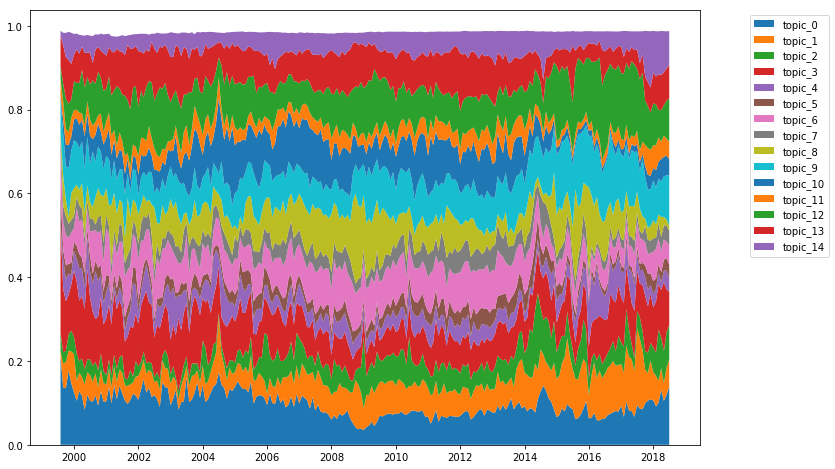

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.stackplot(a.index, a.T.values, labels=list(a.columns))
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.show()

### Слова в топиках

In [20]:
ldamodel1.print_topics()

[(0,
  '0.011*"санкция" + 0.010*"россия" + 0.008*"закон" + 0.008*"решение" + 0.008*"налог" + 0.007*"ввести" + 0.007*"ведомство" + 0.007*"документ" + 0.007*"ограничение" + 0.006*"мера"'),
 (1,
  '0.037*"банка" + 0.031*"банк" + 0.016*"цб" + 0.016*"рубль" + 0.015*"кредитный" + 0.014*"финансовый" + 0.013*"россия" + 0.013*"пенсионный" + 0.012*"кредит" + 0.012*"система"'),
 (2,
  '0.050*"украина" + 0.022*"газа" + 0.020*"россия" + 0.020*"газпром" + 0.019*"российский" + 0.016*"украинский" + 0.014*"поставка" + 0.011*"кубометр" + 0.011*"киев" + 0.010*"доллар"'),
 (3,
  '0.029*"россия" + 0.017*"глава" + 0.015*"2017" + 0.011*"российский" + 0.011*"развитие" + 0.009*"путин" + 0.008*"директор" + 0.008*"владимир" + 0.008*"совет" + 0.008*"экономический"'),
 (4,
  '0.067*"нефть" + 0.033*"баррель" + 0.026*"цена" + 0.025*"добыча" + 0.022*"доллар" + 0.021*"миллион" + 0.020*"тонна" + 0.015*"нефтяной" + 0.013*"опека" + 0.008*"саудовский"'),
 (5,
  '0.032*"тасс" + 0.026*"рейтинг" + 0.016*"s" + 0.016*"агентств

### Топ слова.

In [21]:
word_counts = {}
for s in tqdm_notebook(doc_term_matrix):
    for w in s:
        if w[0] not in word_counts:
            word_counts[w[0]] = w[1]
        else:
            word_counts[w[0]] += w[1]

In [22]:
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [23]:
for w in sorted_word_counts[:50]:
    print(f'{dictionary[w[0]]} - {w[1]} times.')

доллар - 100216 times.
россия - 89654 times.
миллиард - 80676 times.
рубль - 70095 times.
российский - 53585 times.
миллион - 43725 times.
акция - 38384 times.
рынок - 38127 times.
цена - 37752 times.
составить - 34289 times.
банка - 32672 times.
нефть - 32453 times.
правительство - 28745 times.
банк - 28480 times.
сша - 26156 times.
рост - 26055 times.
финансовый - 26007 times.
тысяча - 25334 times.
крупный - 24273 times.
украина - 22296 times.
евро - 21771 times.
около - 19427 times.
экономика - 19137 times.
средство - 18826 times.
вырасти - 18631 times.
пункт - 18467 times.
составлять - 18462 times.
глава - 18407 times.
газета - 18375 times.
курс - 17964 times.
конец - 17907 times.
бюджет - 17839 times.
решение - 17744 times.
газпром - 17554 times.
начало - 17368 times.
проект - 17300 times.
стоимость - 17266 times.
уровень - 17243 times.
фонд - 17216 times.
агентство - 16992 times.
биржа - 16739 times.
новый - 16339 times.
индекс - 16328 times.
писать - 16259 times.
из-за - 16117 t

In [25]:
ldamodel1.print_topics()

[(0,
  '0.011*"санкция" + 0.010*"россия" + 0.008*"закон" + 0.008*"решение" + 0.008*"налог" + 0.007*"ввести" + 0.007*"ведомство" + 0.007*"документ" + 0.007*"ограничение" + 0.006*"мера"'),
 (1,
  '0.037*"банка" + 0.031*"банк" + 0.016*"цб" + 0.016*"рубль" + 0.015*"кредитный" + 0.014*"финансовый" + 0.013*"россия" + 0.013*"пенсионный" + 0.012*"кредит" + 0.012*"система"'),
 (2,
  '0.050*"украина" + 0.022*"газа" + 0.020*"россия" + 0.020*"газпром" + 0.019*"российский" + 0.016*"украинский" + 0.014*"поставка" + 0.011*"кубометр" + 0.011*"киев" + 0.010*"доллар"'),
 (3,
  '0.029*"россия" + 0.017*"глава" + 0.015*"2017" + 0.011*"российский" + 0.011*"развитие" + 0.009*"путин" + 0.008*"директор" + 0.008*"владимир" + 0.008*"совет" + 0.008*"экономический"'),
 (4,
  '0.067*"нефть" + 0.033*"баррель" + 0.026*"цена" + 0.025*"добыча" + 0.022*"доллар" + 0.021*"миллион" + 0.020*"тонна" + 0.015*"нефтяной" + 0.013*"опека" + 0.008*"саудовский"'),
 (5,
  '0.032*"тасс" + 0.026*"рейтинг" + 0.016*"s" + 0.016*"агентств

In [ ]:
## %%time
start = 2
limit = 15
step = 1
model_list, coherence_values = tm_functions.compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix,
                                                                     texts=data['new_text'].values,
                                                                     start=start, limit=limit, step=step, use_multicore=True)

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 8))
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество топиков")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

NameError: name 'coherence_values' is not defined

<Figure size 864x576 with 0 Axes>